Starting setup process...
Installing the 'contractions' library...
Installation complete.
All libraries imported successfully.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


NLTK downloads complete.

Dataset loaded successfully!

--- Dataset First Look ---
  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          201

/tmp/ipython-input-3672520145.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['director'].fillna('Unknown', inplace=True)
/tmp/ipython-input-3672520145.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

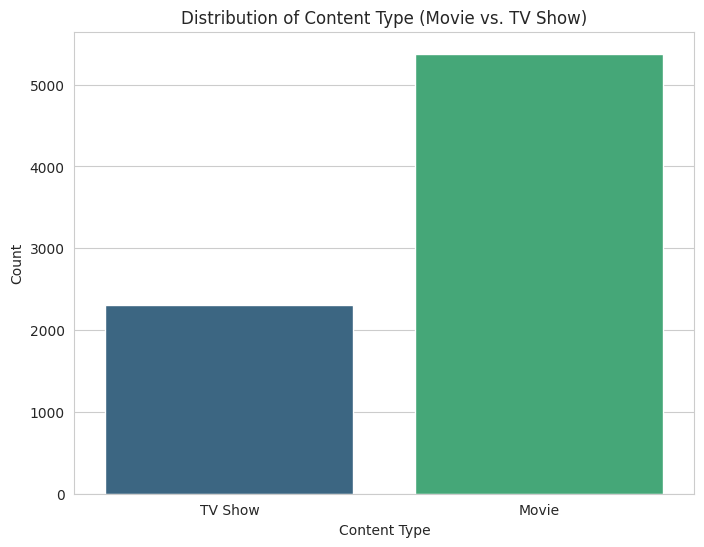

/tmp/ipython-input-3672520145.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')


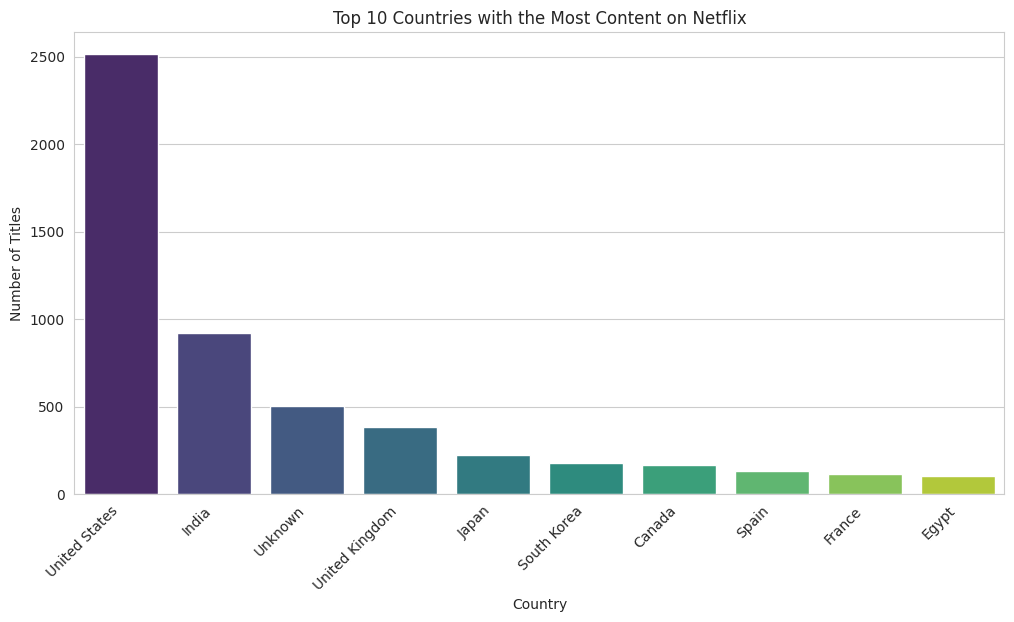

/tmp/ipython-input-3672520145.py:118: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=titles_per_year.index, y=titles_per_year.values, marker='o', palette='viridis')


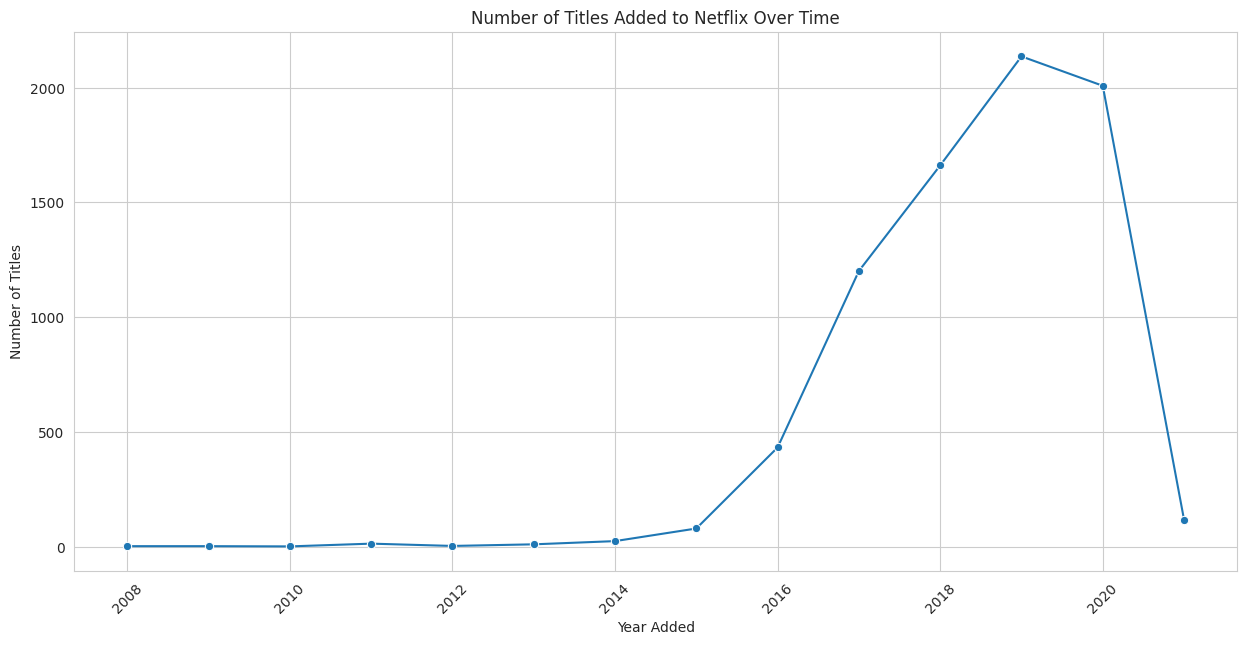


--- Performing Text Preprocessing ---
Text preprocessing and TF-IDF vectorization complete.
Shape of TF-IDF matrix: (7689, 5000)

--- Starting Clustering Analysis ---
Dimensionality reduction with PCA complete.
Reduced number of features: 3233


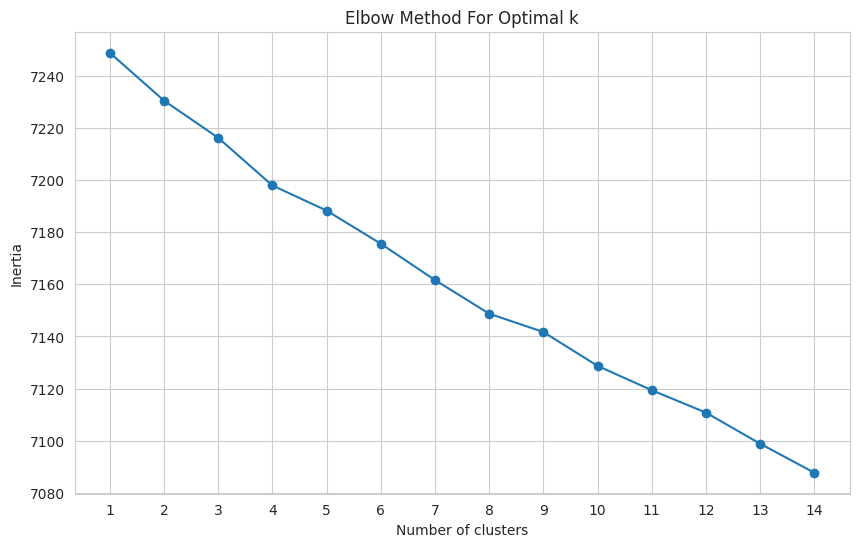

K-Means clustering complete with 5 clusters.
Silhouette Score: 0.0028


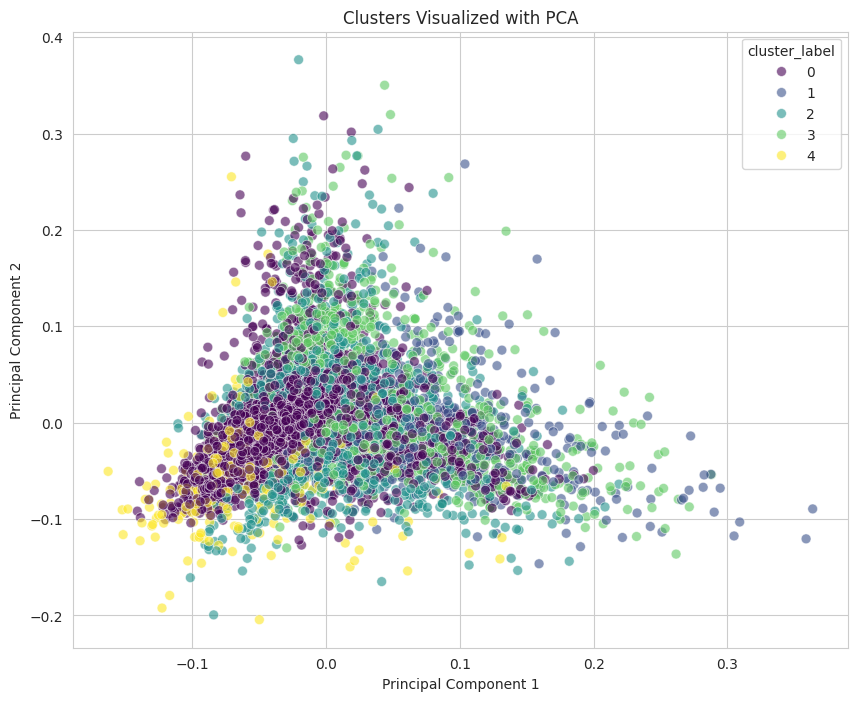

In [ ]:
# ==============================================================================
# 1. Setup: Installing Libraries, Downloading NLTK Data, and Importing
# ==============================================================================
# This cell handles all initial setup, including installing the necessary library
# and downloading the NLTK data, which is a common source of errors if not done first.

print("Starting setup process...")
print("Installing the 'contractions' library...")
# The following line installs the necessary library in the Colab environment.
!pip install contractions
print("Installation complete.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from contractions import fix as fix_contractions # This will now work
print("All libraries imported successfully.")

# Set plot style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

# Download necessary NLTK data (only needs to be run once)
print("Downloading NLTK data (this may take a moment)...")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# ADDED: Download the 'punkt_tab' tokenizer model
nltk.download('punkt_tab')
print("NLTK downloads complete.")


# ==============================================================================
# 2. Data Loading and Initial Exploration
# ==============================================================================
# This cell loads the dataset and provides an initial overview.

# Load the dataset
try:
    df = pd.read_csv('/content/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv')
    print("\nDataset loaded successfully!")
except FileNotFoundError:
    print("\nError: 'NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv' not found.")
    print("Please upload the file to your Colab environment and try again.")
    df = None # Set df to None to prevent errors in subsequent cells.

if df is not None:
    print("\n--- Dataset First Look ---")
    print(df.head())
    print("\n--- Dataset Information ---")
    df.info()
    print("\n--- Missing Values Count ---")
    print(df.isnull().sum())


# ==============================================================================
# 3. Data Wrangling and Preprocessing
# ==============================================================================
# This cell handles missing value imputation and data type conversions.
if df is not None:
    # Handle missing values for key columns by filling with 'Unknown'
    df['director'].fillna('Unknown', inplace=True)
    df['cast'].fillna('Unknown', inplace=True)
    df['country'].fillna('Unknown', inplace=True)
    df['rating'].fillna('Unknown', inplace=True)

    # Drop rows with missing 'date_added' and 'duration' as they are critical
    df.dropna(subset=['date_added', 'duration'], inplace=True)

    # Convert 'date_added' to datetime and extract 'year_added'
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['year_added'] = df['date_added'].dt.year
    df.dropna(subset=['date_added', 'year_added'], inplace=True) # Drop any rows where date conversion failed

    print("\nData wrangling complete.")
    print("\n--- Missing Values After Wrangling ---")
    print(df.isnull().sum())


# ==============================================================================
# 4. Exploratory Data Analysis (EDA)
# ==============================================================================
# This cell generates several visualizations to explore the data.
if df is not None:
    print("\n--- Generating Visualizations ---")
    # Chart 1: Distribution of Content Type
    plt.figure(figsize=(8, 6))
    sns.countplot(x='type', data=df, palette='viridis')
    plt.title('Distribution of Content Type (Movie vs. TV Show)')
    plt.xlabel('Content Type')
    plt.ylabel('Count')
    plt.show()

    # Chart 2: Top 10 Countries with the Most Content
    top_countries = df['country'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
    plt.title('Top 10 Countries with the Most Content on Netflix')
    plt.xlabel('Country')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Chart 3: Number of Titles Added to Netflix Over Time
    titles_per_year = df['year_added'].value_counts().sort_index()
    plt.figure(figsize=(15, 7))
    sns.lineplot(x=titles_per_year.index, y=titles_per_year.values, marker='o', palette='viridis')
    plt.title('Number of Titles Added to Netflix Over Time')
    plt.xlabel('Year Added')
    plt.ylabel('Number of Titles')
    plt.xticks(rotation=45)
    plt.show()


# ==============================================================================
# 5. Text Preprocessing and Vectorization
# ==============================================================================
# This cell cleans the 'description' column and converts it to a TF-IDF matrix.
if df is not None:
    print("\n--- Performing Text Preprocessing ---")
    def text_preprocessing_pipeline(text):
        if not isinstance(text, str): return ""
        text = fix_contractions(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\S*\d\S*', '', text)
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if w.lower() not in stop_words]
        lemmatizer = WordNetLemmatizer()
        lemmatized_text = [lemmatizer.lemmatize(w) for w in filtered_sentence]
        return " ".join(lemmatized_text).strip()

    df['cleaned_description'] = df['description'].apply(text_preprocessing_pipeline)

    # Vectorize the text data using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_description'])
    print("Text preprocessing and TF-IDF vectorization complete.")
    print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")


# ==============================================================================
# 6. Dimensionality Reduction, K-Means Clustering, and Evaluation
# ==============================================================================
# This cell performs PCA, determines the optimal number of clusters, and applies K-Means.
if df is not None:
    print("\n--- Starting Clustering Analysis ---")
    # Reduce the dimensionality of the TF-IDF matrix
    pca = PCA(n_components=0.95)
    pca_result = pca.fit_transform(tfidf_matrix.toarray())
    print("Dimensionality reduction with PCA complete.")
    print(f"Reduced number of features: {pca_result.shape[1]}")

    # Elbow Method to find the optimal number of clusters
    inertia = []
    for i in range(1, 15):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(pca_result)
        inertia.append(kmeans.inertia_)

    # Visualize the Elbow Method results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 15), inertia, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.xticks(range(1, 15))
    plt.show()

    # Fit K-Means with the chosen optimal number of clusters (e.g., 5)
    optimal_clusters = 5
    kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(pca_result)
    df['cluster_label'] = kmeans.labels_
    print(f"K-Means clustering complete with {optimal_clusters} clusters.")

    # Evaluate the clustering with the Silhouette Score
    silhouette_avg = silhouette_score(pca_result, kmeans.labels_)
    print(f"Silhouette Score: {silhouette_avg:.4f}")

    # Visualize the final clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['cluster_label'], palette='viridis', legend='full', s=50, alpha=0.6)
    plt.title('Clusters Visualized with PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
